In [1]:
### Install Qiskit and relevant packages, if needed

%pip install qiskit[visualization]==1.0.2
%pip install qiskit_ibm_runtime
%pip install qiskit_aer
%pip install graphviz

  Using cached qiskit-1.0.2-cp38-abi3-macosx_10_9_x86_64.whl.metadata (12 kB)
  Using cached pylatexenc-2.10.tar.gz (162 kB)
  Preparing metadata (setup.py) ... done
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached qiskit-1.0.2-cp38-abi3-macosx_10_9_x86_64.whl (4.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 703.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 1.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 761.7 kB/s eta 0:00:00a 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 2.2 MB/s eta 0:00:00a 0:00:01m
Using cached tzdata-2024.1

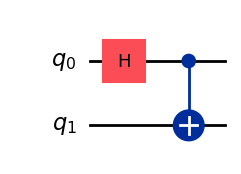

In [4]:
# Imports

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

#More advanced libraries
from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import XGate, YGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization.timeline import draw, IQXStandard
from qiskit.visualization import plot_circuit_layout
from qiskit.quantum_info.analysis import hellinger_fidelity
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt
import numpy as np


# Create a new circuit with two qubits and 2 classical bits for measurement results
qc = QuantumCircuit(2,2)
 
# Step 1: Superposition - Apply Hadamard gate to the first qubit
qc.h(0)

# Step 2: Entanglement - Apply a CNOT (controlled-X) gate
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [39]:
# Step 4: Add Measurement (only call once, or specify individual qubits)
qc.measure()  # Measure qubit 0 into classical bit 0 and qubit 1 into classical bit 1
# Alternatively, use qc.measure_all() once at the end, not multiple times.
qc.draw("mpl")

TypeError: QuantumCircuit.measure() missing 2 required positional arguments: 'qubit' and 'cbit'

<a id='toc2_'></a>
<a name='toc2_'></a>

# Observables

When creating quantum circuits, you must also consider what type of data you want returned after execution. Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure, or you can obtain the expectation value of an observable. Prepare your workload to measure your circuit in one of these two ways with Qiskit primitives
This example measures expectation values by using the qiskit.quantum_info submodule, which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: IZ, IX, ZI, XI, ZZ, and XX

In [5]:
# Set up six different observables.
from qiskit.quantum_info import SparsePauliOp
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

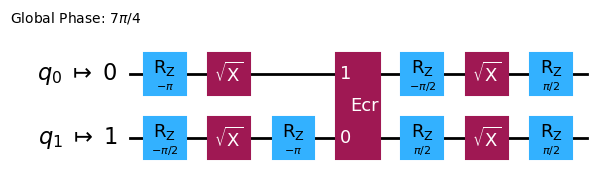

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_quantum", token="fa97f80bcc2e41a2cc0364df496b446de8eb75962ca3bad14d8a9fe5ac40994d753806b1e59910f6a129e8ad28ad86cc122d41571b2c10b572ada2b18325bd1a")
#service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw('mpl', idle_wires=False)


# Execute using the quantum primitives
Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the Estimator class. Estimator is one of two primitives; the other is Sampler, which can be used to get data from a quantum computer. These objects possess a run() method that executes the selection of circuits, observables, and parameters (if applicable), using a primitive unified bloc (PUB).

In [31]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cve1h0wp7drg008kwezg


In [21]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

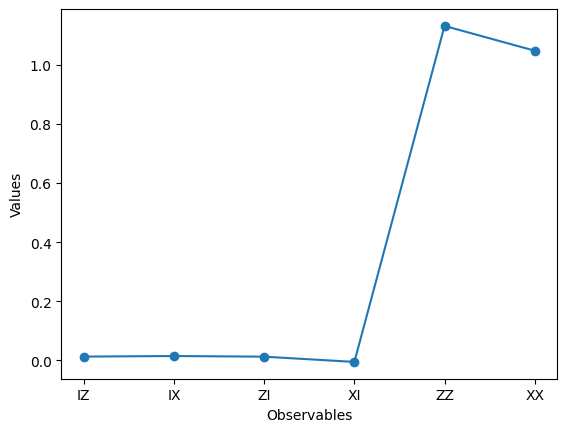

In [28]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (XX and ZZ) are 1. This is a hallmark of quantum entanglement.

# Why This is a Hallmark of Entanglement:
Zero independent expectation values: If the qubits were not entangled, they could individually show some bias or expectation in either the X or Z basis. However, in an entangled state, their independent measurements average to 0 because the state has no definite value unless measured jointly.

Perfect correlations: The fact that the measurement outcomes in the X and Z bases are perfectly correlated is a hallmark of entanglement. This means the qubits are in a shared state where knowing the outcome of one qubit immediately tells you the outcome of the other, regardless of how far apart they are.